<a href="https://colab.research.google.com/github/tzvikif/Bananas/blob/main/BananasTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports and CONSTANS


In [ ]:
#from google.colab import files
#uploaded = files.upload()


In [ ]:
!pip install rasterio
!pip install albumentations==0.4.6
!pip install tifffile

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/MyDrive/BananaTrees/Bananas'
from utils import mean_average_precision

/content/gdrive/MyDrive/BananaTrees/Bananas


##For checkpoints

In [ ]:
# Imports
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torchvision
import os
import cv2
import glob
from skimage import io
from torch.utils.data import Dataset, DataLoader # Gives easier dataset managment and creates mini batches
import xml.etree.ElementTree as et #for xml parsing
import rasterio as rs #reads geotiff files
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib import pyplot as plt
from matplotlib import patches as patches

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from datetime import datetime
#sklearn
from sklearn.model_selection import KFold
from utils import subset_of_data

DIR_ANNOTATIONS = '/content/gdrive/MyDrive/data/PalmTrees/Training'
DIR_IMAGES = '/content/gdrive/MyDrive/data/PalmTrees/Training'
#DIR_TRAIN = f'{DIR_INPUT}/Training'
#DIR_TEST = f'{DIR_INPUT}/test'
LOAD_WEIGHTS = True
SAVE_WEIGHTS = False
SKIP_TRAINING = True
NUM_EPOCHS = 5
now = datetime.now()
current_time = now.strftime("%d%m_%H%M")
#WEIGHTS_FILENAME = f'my_checkpoint{current_time}.pth.tar'
file_id = ''
WEIGHTS_FILENAME = f'/content/gdrive/MyDrive/BananaTrees/weights/my_checkpoint.pth.tar'
WEIGHTS_BANANAS_FILENAME = f'/content/gdrive/MyDrive/BananaTrees/weights/bananas_checkpoint.pth.tar'
INIT_WEIGHTS_FILENAME = '/content/gdrive/MyDrive/BananaTrees/weights/init_checkpoint.pth.tar'

In [ ]:
def save_checkpoint(state, filename):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


##Create train/validation set

At first stage using *palm trees* datasets

In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
def get_train_transform_tensor():
    return A.Compose([
        ToTensorV2(p=1.0)
    ],)
def get_train_transform_tensor():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])


def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


## **Create the model**

In [ ]:
# load a model; pre-trained on COCO
model =   

In [ ]:
num_classes = 2  # 1 class (Palm) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
#model

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

##Train

In [ ]:

class BananaTreesDataset(Dataset):
    def __init__(self,images_dir,annotations_path,transforms=None):
        self.root_dir = images_dir
        #self.annotations = self.get_annotations(annotations_path)
        self.annotations = self.get_tiles_annotations(annotations_path)
        self.transforms = transforms
    def __len__(self):
        #print(f'len:{len(self.annotations)}')
        return len(self.annotations)
    def __getitem__(self,index):
        current = self.annotations[index]
        img_name = current['filename']
        bboxes = current['bboxes']
        img_path = os.path.join(self.root_dir,img_name)
        #print(f'image_path:{img_path}')
        img =Image.open(img_path)
        image = np.asfarray(img)
        #image = torch.as_tensor(img,dtype=torch.float16)
        #image = np.transpose(img,(2,0,1))
        image /= 255
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.ones((bboxes.shape[0],), dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((bboxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = bboxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            #print(f'image.shape:{image.shape:}, bboxes:{target["boxes"]}')
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            #print(f'** shape:{image.shape}')
            sample = self.transforms(**sample)
            #print(f'** after transform **:{sample["bboxes"]}')
            image = sample['image']
            try:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            except RuntimeError as e:
                pass
        return image, target, img_name
    def get_tiles_annotations(self,annotations_path):
        annotations = []
        with open(annotations_path) as json_file:
            data = json.load(json_file)
            for f in data:
                filename = f['filename']
                bboxes_temp = f['bboxes']
                bboxes = np.zeros([len(bboxes_temp),4])
                for i,box in enumerate(bboxes_temp):
                    bboxes[i,:] = bboxes_temp[i]
                annotations.append({'filename':filename,'bboxes':bboxes})
        return annotations
    def get_annotations(self,annotations_path):
        annotations = []
        with open(annotations_path) as json_file:
            data = json.load(json_file)
            for key in data.keys():
                current_file = data[key]
                filename = current_file['filename']
                imsize = current_file['size']
                regions = current_file['regions']
                d = DefaultDict()
                d['filename'] = filename
                bboxes = np.zeros([len(regions),4])
                for i,attrib in enumerate(regions):
                    shape_attrib = attrib['shape_attributes']
                    xmin = shape_attrib['x']
                    ymin = shape_attrib['y']
                    xmax = xmin + shape_attrib['width']
                    ymax = ymin + shape_attrib['height']
                    bboxes[i,:] = xmin,ymin,xmax,ymax
                d['bboxes'] = bboxes
                annotations.append(d)
        return annotations

In [ ]:
import json
from typing import DefaultDict
from PIL import Image

def collate_fn(batch):
    return tuple(zip(*batch))      

train_images_dir = '/content/gdrive/MyDrive/BananaTrees/data/batch_A_banana/train'
valid_images_dir = '/content/gdrive/MyDrive/BananaTrees/data/batch_A_banana/valid'
train_annoations_path = '/content/gdrive/MyDrive/BananaTrees/data/batch_A_banana/annotations_train.json'
valid_annoations_path = '/content/gdrive/MyDrive/BananaTrees/data/batch_A_banana/annotations_valid.json'
train_banana_data_set = BananaTreesDataset(train_images_dir,train_annoations_path,get_train_transform())
valid_banana_data_set = BananaTreesDataset(valid_images_dir,valid_annoations_path,get_valid_transform())
train_banana_data_loader = DataLoader(
      train_banana_data_set,
      batch_size=4,
      shuffle=False,
      num_workers=1,
      collate_fn=collate_fn
  )
valid_banana_data_loader = DataLoader(
      valid_banana_data_set,
      batch_size=4,
      shuffle=False,
      num_workers=1,
      collate_fn=collate_fn
  )

#Bananas samples

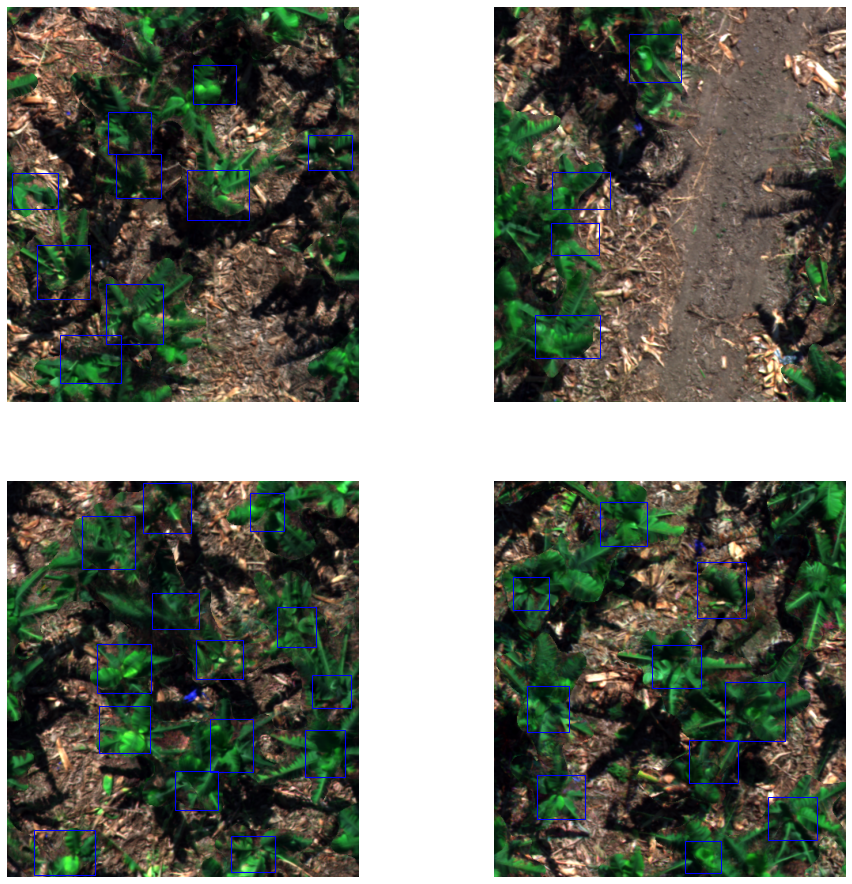

In [ ]:
def display_sample(data_loader):
    images, targets, image_ids = next(iter(data_loader))
    boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
    fig, ax = plt.subplots(2, 2, figsize=(16, 16))
    for i,(sample,image_id) in enumerate(zip(images,image_ids)):
      sample = np.transpose(sample,(1,2,0))
      ax[i%2,i//2].set_axis_off()
      boxes = targets[i]['boxes']
      for box in boxes:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1], edgecolor='b', facecolor="none")
        ax[i%2,i//2].add_patch(rect)    
      ax[i%2,i//2].imshow(sample)
    plt.show()

display_sample(train_banana_data_loader)


#Check Point

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None
if LOAD_WEIGHTS == True:
  load_checkpoint(WEIGHTS_BANANAS_FILENAME, model, optimizer)



=> Loading checkpoint


In [ ]:
def train(train_data_loader):
  losses_list = []
  model.train()
  loss_hist = Averager()
  itr = 1
  for epoch in range(NUM_EPOCHS):
      loss_hist.reset()
      
      for images, targets, image_ids in train_data_loader:
          for idx,t in enumerate(targets):
            for k,v in t.items():
              try:
                v.to(device)
              except:
                print(v)
                print(type(v))
                print(image_ids[idx])
          images = list(image.to(device,dtype=torch.float) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

          loss_dict = model(images, targets)
          #print(f'loss_dict:{loss_dict}')
          losses = sum(loss for loss in loss_dict.values())
          loss_value = losses.item()

          loss_hist.send(loss_value)

          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

          if itr % 50 == 0:
              print(f"Iteration #{itr} loss: {loss_value}")

          itr += 1
      
      # update the learning rate
      if lr_scheduler is not None:
          lr_scheduler.step()
      print(f"Epoch #{epoch} loss: {loss_hist.value}")
      losses_list.append(loss_value)
  return losses_list
if not SKIP_TRAINING:
  train(train_banana_data_loader)
if SAVE_WEIGHTS:
  checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
  save_checkpoint(checkpoint,WEIGHTS_BANANAS_FILENAME)  

In [ ]:
def loss_plot(losses):
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.set_title('Losses')
  ax.plot(losses)
  #ax.legend(loc='upper left')
  ax.set_ylabel('Average Loss')
  ax.set_xlabel('#Epochs')

#loss_plot(losses_list)

##Validation

In [ ]:
#def display_samples(images,outputs,image_ids=[None]*len(images)):
def display_samples(images,targets,image_ids):
  
  cpu_device = torch.device("cpu")
  images = list(img.to(device,dtype=torch.float) for img in images)
  model.eval()
  outputs = model(images)
  print(f'tile name:{image_ids[0]} {outputs[0]}')
  print('after eval')
  outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
  samples = [image.permute(1,2,0).cpu().numpy() for image in images]
  fig, ax = plt.subplots(2, 2, figsize=(16, 16))
  for i,(sample,image_id) in enumerate(zip(samples,image_ids)):
    ax[i%2,i//2].set_axis_off()
    boxes = outputs[i]['boxes']
    for box in boxes:
      rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1], edgecolor='r', facecolor="none")
      ax[i%2,i//2].add_patch(rect)    
      
    boxes = targets[i]['boxes']
    num_boxes=len(boxes)
    for box in boxes:
      rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1], edgecolor='b', facecolor="none")
      ax[i%2,i//2].add_patch(rect)  
    if image_id!=None:
      ax[i%2,i//2].set_title(image_id[:-4]+' '+str(num_boxes))  
    ax[i%2,i//2].imshow(sample)


tile name:tile_38_0_0.png {'boxes': tensor([[192.3105, 390.7346, 252.2282, 444.9219],
        [339.7574, 139.8057, 416.7288, 205.7352],
        [317.9645, 427.7213, 398.5959, 490.5556],
        [306.8326, 255.7095, 362.5479, 308.6055],
        [285.2689, 351.7615, 335.6482, 399.2236],
        [252.2574, 237.3404, 392.2659, 367.3525],
        [343.9498, 311.3074, 388.7137, 362.6072],
        [152.2680, 399.6404, 202.7055, 444.8928],
        [162.5798, 364.3959, 259.3311, 447.8178]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.9932, 0.9622, 0.8787, 0.7515, 0.5568, 0.1694, 0.0681, 0.0593],
       device='cuda:0', grad_fn=<IndexBackward>)}
after eval


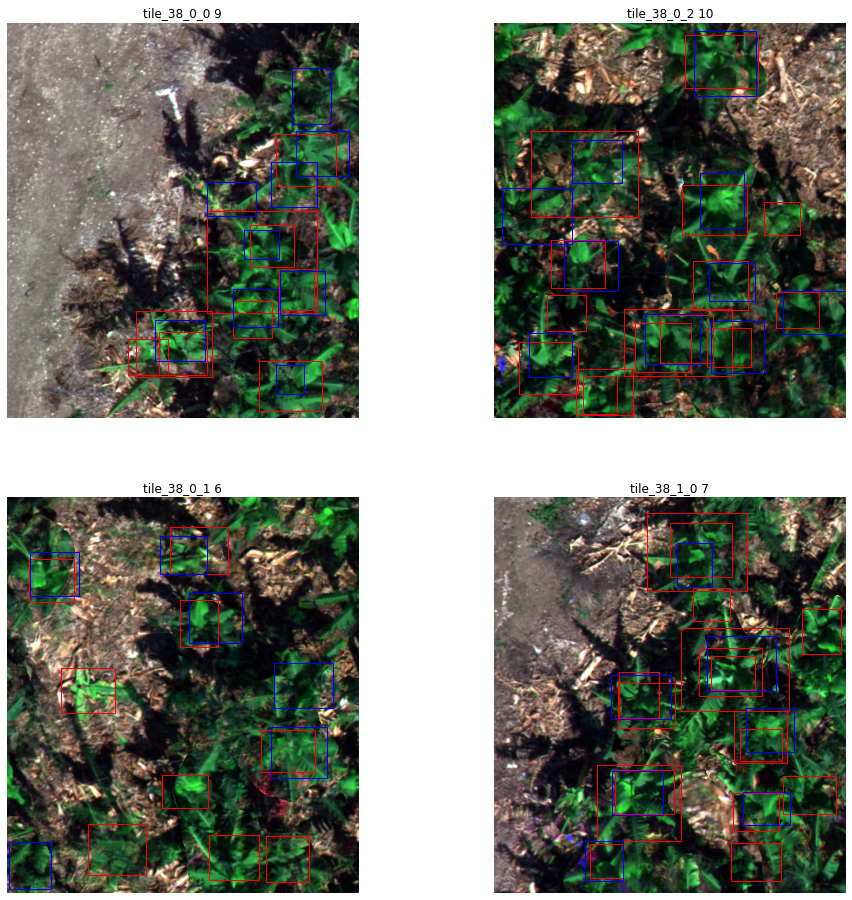

In [ ]:
images, targets, image_ids = next(iter(valid_banana_data_loader))
display_samples(images, targets, image_ids)

#Create annotation for prediction

In [ ]:
from typing import DefaultDict
import json

def create_annotaion_file(banana_data_loader,dest_path):
  annotations = []
  for images, targets, image_ids in banana_data_loader:
    cpu_device = torch.device("cpu")
    images = list(img.to(device,dtype=torch.float) for img in images)
    model.eval()
    outputs = model(images)
    #print(f'tile name:{image_ids[0]} {outputs[0]}')
    #print('after eval')
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    for output,image_id in zip(outputs,image_ids):
      bboxes = [bbx.detach().numpy().tolist() for bbx in output['boxes']]
      d = DefaultDict()
      d['filename'] = image_id
      d['bboxes'] = bboxes
      print(f'd:{d}')
      annotations.append(d)
  with open(dest_path, "w") as write_file:
        json.dump(annotations, write_file)

  

In [ ]:
create_annotaion_file(valid_banana_data_loader,"prediction_annotations.json")

#Metric Calculation
###Mean Average Precision




In [ ]:
model.eval()
cpu_device = torch.device("cpu")
#dict_keys(['boxes', 'labels', 'scores'])
#outputs = model(images)
#move the key/value to cpu
#outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
def prepare_for_mAP(valid_data_loader):
  '''
  :input data loader
  :return (pred_boxes,true_boxes)
  '''
  pred_boxes = []
  true_boxes = []
  with torch.no_grad():
    for i,(images, targets, image_ids) in enumerate(valid_data_loader):
      images = list(img.to(device,dtype=torch.float) for img in images)
      outputs = model(images)
      outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
      for idx,image_pred in enumerate(outputs): #for each image
        boxes = image_pred['boxes']
        labels = image_pred['labels']
        scores = image_pred['scores']
        for i,box in enumerate(boxes): #for each bbox
          pred_boxes.append([image_ids[idx],labels[i]-1,scores[i],box[0],box[1],box[2],box[3]])

      for idx,gt in enumerate(targets):
        boxes = gt['boxes']
        labels = gt['labels']
        for i,box in enumerate(boxes):
          true_boxes.append([image_ids[idx],labels[i]-1,1.0,box[0],box[1],box[2],box[3]])
  return (pred_boxes,true_boxes)
  



In [ ]:
#format for pred_boxes,true_boxes [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
pred_boxes,target_boxes = prepare_for_mAP(valid_banana_data_loader)
print(len(pred_boxes))
print(len(target_boxes))

#print(f'pred_boxes:{pred_boxes[0,3:6]} true_boxes:{true_boxes[0,3:6]}')
#mean_average_precision(pred_boxes=pred_boxes,true_boxes=true_boxes,iou_threshold=0.5,box_format='corners',num_classes=1)

380
237


In [ ]:
def evaluate_model(valid_data_loader,threshold=0.5):
  model.eval()
  cpu_device = torch.device("cpu")
  samples = [image.permute(1,2,0).cpu().numpy() for image in images]
  pred_boxes,true_boxes = prepare_for_mAP(valid_data_loader)
  mAP = mean_average_precision(pred_boxes=pred_boxes,true_boxes=true_boxes,iou_threshold=threshold,box_format='corners',num_classes=1)
  return mAP

In [ ]:
#thresholds = np.arange(start=0.3, stop=0.3, step=0.05)
thresholds = [0.4]
mAP_sum = 0
for threshold in thresholds:
  current_mAP = evaluate_model(valid_banana_data_loader,threshold)
  mAP_sum += current_mAP
mAP = mAP_sum/len(thresholds)
print(f'mAP:{mAP:.3f}')

mAP:0.700
